In [5]:
import ROOT
%jsroot on

import numpy
import root_numpy
import pandas
import xgboost
from sklearn.cross_validation import train_test_split
from sklearn.utils import shuffle
from sklearn import metrics
import utils
import tmva_utils
import math

from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier                                                                                                                                                      


Welcome to JupyROOT 6.10/09


/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs_depscipy/3.0-elfike/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-matplotlib/1.5.2-fmblme/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
def prec_xgb(n_trees, max_depth, X_train, y_train, X_test, y_test, weight_train, learning_rate=0.3):
    """
    ExtraTrees
    """
    import xgboost as xgb
    X_train = X_train.reshape((X_train.shape[0], -1))
    X_test = X_test.reshape((X_test.shape[0], -1))
    
#    LOGGER.info('start predict: n_trees={},X_train.shape={},y_train.shape={},X_test.shape={},y_test.shape={}'.format(
    print 'start predict: n_trees={},X_train.shape={},y_train.shape={},X_test.shape={},y_test.shape={}'.format(n_trees, X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    clf = xgb.XGBClassifier(n_estimators=n_trees, max_depth=max_depth, objective='multi:softprob',
            seed=0, silent=True, nthread=-1, learning_rate=learning_rate)
    eval_set = [(X_test, y_test)]
    clf.fit(X_train, y_train, eval_set=eval_set, eval_metric="merror", sample_weight = weight_train)
    y_pred = clf.predict(X_test, output_margin=True)
    y_pred_prob = clf.predict_proba(X_test)

    prec = float(numpy.sum(y_pred == y_test)) / len(y_test)
#    LOGGER.info('prec_xgb_{}={:.6f}%'.format(n_trees, prec*100.0))
    print 'prec_xgb_{}={:.6f}%'.format(n_trees, prec*100.0)
    return clf, y_pred, y_pred_prob

In [3]:
def GetDatasets(inputfile, extraBranches, mySelection):
    train_frac = 0.5
    f = ROOT.TFile(inputfile, 'UPDATE')
    #f = ROOT.TFile("/home/users/hmei/ttH/Loopers/MVABaby_ttHHadronic_multiClass_promptness_toptag.root", 'UPDATE')
    tree = f.Get("t")

    # load tree to array
    feature_names = (root_numpy.tree2array(tree, branches = ["mva_branches"], start=0, stop=1))[0][0]
    feature_names = list(feature_names) 
#    feature_names = feature_names[1:len(feature_names)]
    print feature_names
    allBranches = numpy.concatenate( (feature_names, extraBranches) )
    features_raw = root_numpy.tree2array(tree, branches = allBranches, selection = mySelection) 
    # print features_raw
    features = []
    for feature in feature_names:
        features.append(features_raw[feature])

    #features = numpy.asarray(features)
    features = numpy.transpose(features)
    labels = root_numpy.tree2array(tree, branches = "label_", selection = mySelection)
    weights = root_numpy.tree2array(tree, branches = "evt_weight_", selection = mySelection) 

    extra_arrays = {}
    for extraBranch in extraBranches:
        type_ = features_raw[extraBranch].dtype
        extra_arrays[extraBranch] = numpy.array( features_raw[extraBranch], dtype = [(extraBranch, type_)] )

    return features, labels, weights, extra_arrays

In [4]:
def Train1(d_train, d_test, doBinary, n_round, sum_neg_weights = 1, sum_pos_weights = 1):
    # Define BDT parameters
    param1 = { 
    	    'max_depth': 8,
            'eta': 0.3,
            'objective': 'multi:softprob',#'multi:softmax',
            'num_class': 5,
            'subsample': 1.0,
            'colsample_bytree': 1.0,
            'nthread' : 8,
            }
    
    param2 = { 
    	    'max_depth': 4,
            'eta': 0.3,
            'objective': 'binary:logistic',
#            'scale_pos_weight': sum_neg_weights / sum_pos_weights,
            'subsample': 1,
            'colsample_bytree': 1.0,
            'nthread' : 8,
            }

    #n_round = 100
    evallist = [(d_train, 'train'), (d_test, 'test')]
    progress = {}

    #clf, y_pred, y_pred_prob = prec_xgb(100, 8, x_train, y_train, x_test, y_test, weights_train1)
    #print y_pred, y_pred_prob
    param = param1
    if doBinary:
        param = param2
    bdt = xgboost.train(param, d_train, n_round, evallist, evals_result = progress)	

    d_pred_train = bdt.predict(d_train)#, output_margin=True)
    d_pred_test = bdt.predict(d_test)#, output_margin=True)

    return d_pred_train, d_pred_test

In [8]:
nround1 = 100
nround2 = 10

#filename = "../Loopers/MVABaby_ttHHadronic_multiClass_promptness_toptag_forHggMeeting.root"
filename = "../Loopers/MVABaby_ttHHadronic_multiClass_promptness_toptag4.root"
outname = "test_multiclass_weight"

features_train, labels_train, weights_train, extraArrays_train = GetDatasets(filename, ["evt_weight_", "process_id_", "mass_"], "label_ < 5 && rand_ < 0.5")
features_test, labels_test, weights_test, extraArrays_test = GetDatasets(filename, ["evt_weight_", "process_id_", "mass_"], "label_ < 5 && rand_ > 0.5")

scale_sig = utils.sum_of_weights(weights_train, labels_train, 0)
scale_bkg1 = utils.sum_of_weights(weights_train, labels_train, 1)
scale_bkg2 = utils.sum_of_weights(weights_train, labels_train, 2)
scale_bkg3 = utils.sum_of_weights(weights_train, labels_train, 3)
scale_bkg4 = utils.sum_of_weights(weights_train, labels_train, 4)
scale_bkg = scale_bkg1 + scale_bkg2 + scale_bkg3 + scale_bkg4

for i in range(len(weights_train)):
    if labels_train[i] == 0:
        weights_train[i] *= scale_bkg/scale_sig
        
d_train = xgboost.DMatrix(features_train, label = labels_train, weight = weights_train)
d_test = xgboost.DMatrix(features_test, label = labels_test)

# first training of a multi-class BDT
d_pred_train, d_pred_test = Train1(d_train, d_test, False, nround1)

# modify label
labels_train[labels_train > 0] = -1
labels_train[labels_train == 0] = 1
labels_train[labels_train == -1] = 0

labels_test[labels_test > 0] = -1
labels_test[labels_test == 0] = 1
labels_test[labels_test == -1] = 0

# change training weight for binary output BDT
sum_neg_weights = utils.sum_of_weights(weights_train, labels_train, 0)
sum_pos_weights = utils.sum_of_weights(weights_train, labels_train, 1)

d_train2 = xgboost.DMatrix(d_pred_train, label = labels_train, weight = weights_train)
d_test2 = xgboost.DMatrix(d_pred_test, label = labels_test)

# second training of a binary BDT
d_pred_train2, d_pred_test2 = Train1(d_train2, d_test2, True, nround2, sum_neg_weights, sum_pos_weights)

# save information into a root tree
arrays_forTree = []
for key in extraArrays_test:
    arrays_forTree.append( extraArrays_test[key] )
arrays_forTree.append( numpy.array( d_pred_test2, dtype = [("mva_score_", numpy.float64)] ) ) 
arrays_forTree.append( numpy.array( d_pred_test[:,0], dtype = [("mva_score1_", numpy.float64)] ) ) 
arrays_forTree.append( numpy.array( labels_test, dtype = [("label_", numpy.float64)] ) ) 

hfile = ROOT.TFile('rootfiles/' + outname + ".root","RECREATE");
tree_out = root_numpy.array2tree(numpy.transpose(arrays_forTree[0]))
for i in range(1, len(arrays_forTree)):
    root_numpy.array2tree(numpy.transpose(arrays_forTree[i]), tree=tree_out)

tree_out.Print()
hfile.Write()
hfile.Close()


['topTag_score_', 'dipho_delta_R', 'njets_', 'ht_', 'leadptoM_', 'subleadptoM_', 'maxIDMVA_', 'minIDMVA_', 'lead_eta_', 'sublead_eta_', 'jet1_pt_', 'jet1_eta_', 'jet1_btag_', 'jet2_pt_', 'jet2_eta_', 'jet2_btag_', 'jet3_pt_', 'jet3_eta_', 'jet3_btag_', 'jet4_pt_', 'jet4_eta_', 'jet4_btag_', 'jet5_pt_', 'jet5_eta_', 'jet5_btag_', 'jet6_pt_', 'jet6_eta_', 'jet6_btag_', 'max1_btag_', 'max2_btag_', 'leadPSV_', 'subleadPSV_', 'dipho_cosphi_', 'dipho_rapidity_', 'met_', 'nb_loose_']
['topTag_score_', 'dipho_delta_R', 'njets_', 'ht_', 'leadptoM_', 'subleadptoM_', 'maxIDMVA_', 'minIDMVA_', 'lead_eta_', 'sublead_eta_', 'jet1_pt_', 'jet1_eta_', 'jet1_btag_', 'jet2_pt_', 'jet2_eta_', 'jet2_btag_', 'jet3_pt_', 'jet3_eta_', 'jet3_btag_', 'jet4_pt_', 'jet4_eta_', 'jet4_btag_', 'jet5_pt_', 'jet5_eta_', 'jet5_btag_', 'jet6_pt_', 'jet6_eta_', 'jet6_btag_', 'max1_btag_', 'max2_btag_', 'leadPSV_', 'subleadPSV_', 'dipho_cosphi_', 'dipho_rapidity_', 'met_', 'nb_loose_']
[0]	train-merror:0.093048	test-merro

[12:27:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=8
[12:27:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[12:27:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=8
[12:27:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=8
[12:27:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=8
[12:27:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=8
[12:27:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[12:27:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=8
[12:27:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned node

In [9]:
-

[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0] [( 0.99675304,), ( 0.99632782,), ( 0.99594766,), ( 0.99561322,), ( 0.99530172,), ( 0.99496979,), ( 0.99466902,), ( 0.99437088,), ( 0.9940843,), ( 0.99379069,), ( 0.9935056,), ( 0.99323249,), ( 0.99295467,), ( 0.99265975,), ( 0.99237603,), ( 0.99208939,), ( 0.99177998,), ( 0.99149996,), ( 0.99117345,), ( 0.99084431,), ( 0.99052072,), ( 0.99016643,), ( 0.98983407,), ( 0.9895013,), ( 0.98911577,), ( 0.9887592

In [2]:
def prepareInputs(inputs, colors, styles, keysForPlot, txtfiles, colorlists, linestyles):
    for i in range(len(keysForPlot)):
        inputs[keysForPlot[i]] = numpy.loadtxt(txtfiles[i], usecols=(0,1,2), unpack=True)
        colors[keysForPlot[i]] = colorlists[i]
        styles[keysForPlot[i]] = linestyles[i]

In [3]:
%matplotlib inline
from io import StringIO
import matplotlib
import matplotlib.pyplot as plt

{'multi': 'b', 'multi_weight': 'g'} {'multi': '-', 'multi_weight': '--'}


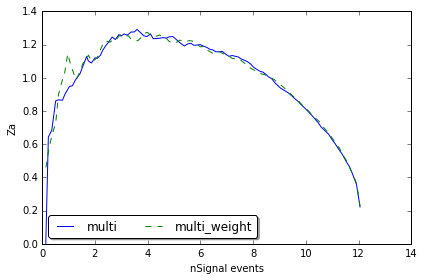

In [7]:
keysForPlot = ["multi", "multi_weight"]
txtfiles = ["txtfiles/test_multiclass.txt", "txtfiles/test_multiclass_weight.txt"]
colorlists = ["b","g"]
linestyles = ["-","--"]

inputs = {}
colors = {}
styles = {}

prepareInputs(inputs, colors, styles, keysForPlot, txtfiles, colorlists, linestyles)

print colors, styles

fig = plt.figure()
fig, ax1 = plt.subplots()

for key in keysForPlot:
#  if key ==  "sig_1_bkg_1" or key == "sig_1_bkg_0.5":
    ax1.plot(inputs[key][0], inputs[key][1], color=colors[key], label=key, linestyle = styles[key])
    #linestyle = '--', dashes = (5,2)

ax1.legend(loc="lower left", #bbox_to_anchor=[0, 1],                                                                                                                                                        
           ncol=2, shadow=True, fancybox=True)
ax1.set_xlabel('nSignal events')
ax1.set_ylabel('Za')


fig.tight_layout()
#plt.show() 
plt.savefig("/home/users/hmei/public_html/2018/20181018_ttH_had/maxZa_weight_multi.png")